# Team Aliverti-Piuri, Amadore, Concheri, Romboni, Stucchi

# TITOLO

## Table of Contents

1. [Transpilation Alternatives](#chapter-2-transpilation-alternatives)
    - [ZX Calculus Simplification Strategy](#zx-calculus-simplification-strategy)
    - [Compatibility with Error Mitigation](#compatibility-with-error-mitigation)


# Chapter 2: Transpilation Alternatives

## ZX Calculus Simplification Strategy

In [1]:
from qiskit.circuit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer
import numpy as np

import pyzx as zx
import random

from my_rem import *
from my_ddd import *
from my_lib import *

from typing import List, Callable
import numpy as np
from matplotlib import pyplot as plt

import qiskit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
import qiskit.quantum_info as qi

from mitiq.interface.mitiq_qiskit import to_qiskit
from mitiq import ddd, QPROGRAM
from mitiq.ddd import insert_ddd_sequences

from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel, pauli_error, depolarizing_error, phase_damping_error, phase_amplitude_damping_error, coherent_unitary_error

In this section, we investigate a technique to reduce the complexity of the circuit based on [ZX calculus](https://quantum-journal.org/papers/q-2020-06-04-279/). This allows for quantum circuit optimisation, by interpreting the  quantum circuits as ZX-diagrams. 

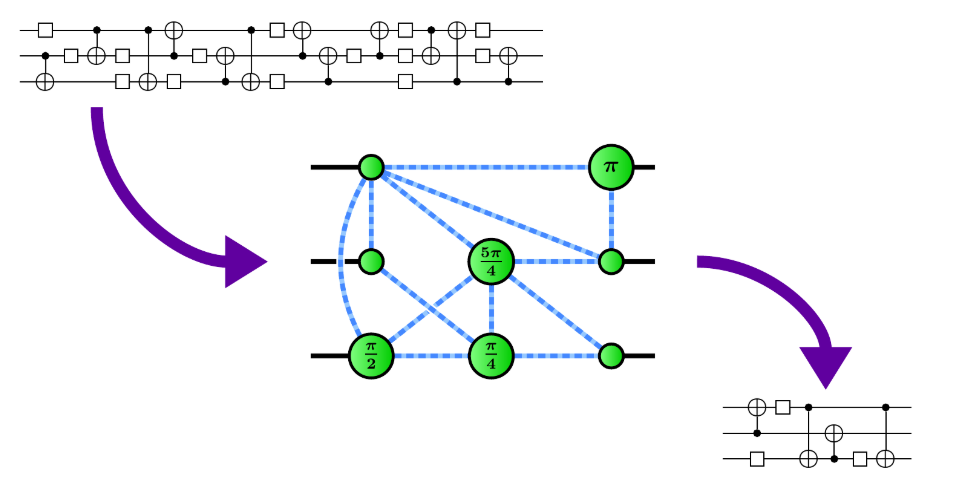

For Clifford circuits, this optimization procedure yields a new normal form that is both asymptotically optimal in size and gives a new, smaller upper bound on gate depth for nearest-neighbour architectures. We give one such example in the code.

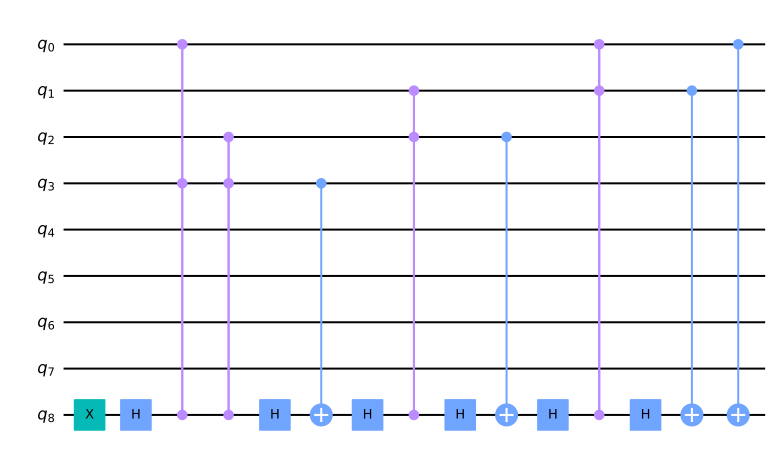

In [2]:
# Adapted from https://github.com/Quantomatic/pyzx/blob/master/circuits/Fast/mod5_4_before
qc = QuantumCircuit(9)
qc.x(8)
qc.h(8)
qc.ccz(0, 3, 8)
qc.ccz(2, 3, 8)
qc.h(8)
qc.cx(3, 8)
qc.h(8)
qc.ccz(1, 2, 8)
qc.h(8)
qc.cx(2, 8)
qc.h(8)
qc.ccz(0, 1, 8)
qc.h(8)
qc.cx(1, 8)
qc.cx(0, 8)

qc.draw(output='mpl', style='clifford')

We now process the input circuit with the custom ZX and save the updated circuit.

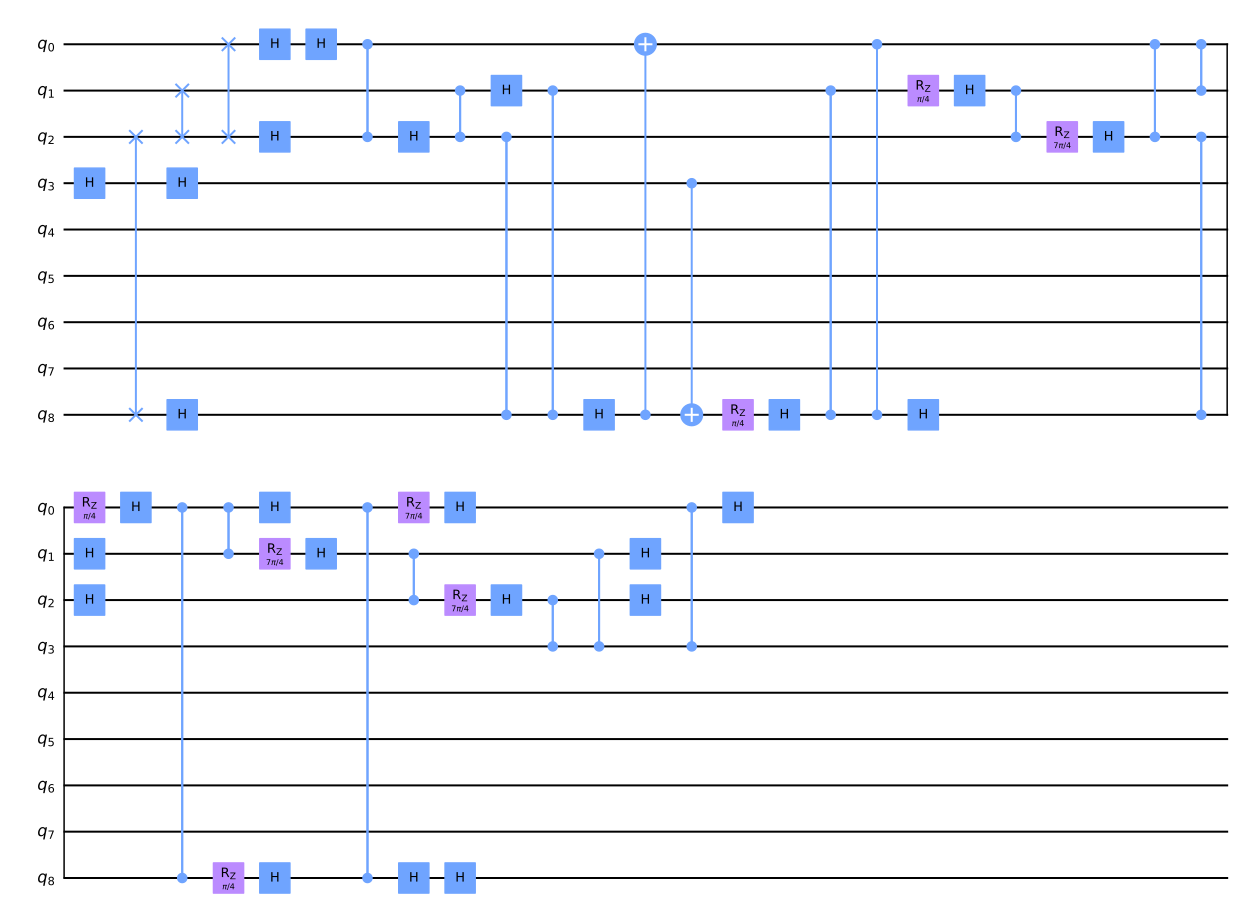

In [3]:
from qiskit.transpiler import PassManager
from zxpass import ZXPass

zxpass = ZXPass()
pass_manager = PassManager(zxpass)

zx_qc = pass_manager.run(qc)
zx_qc.draw(output='mpl', style='clifford')

We also optimize the circuit with the default transpiler from qiskit in order to compare the performance (depth-wise) of the two.

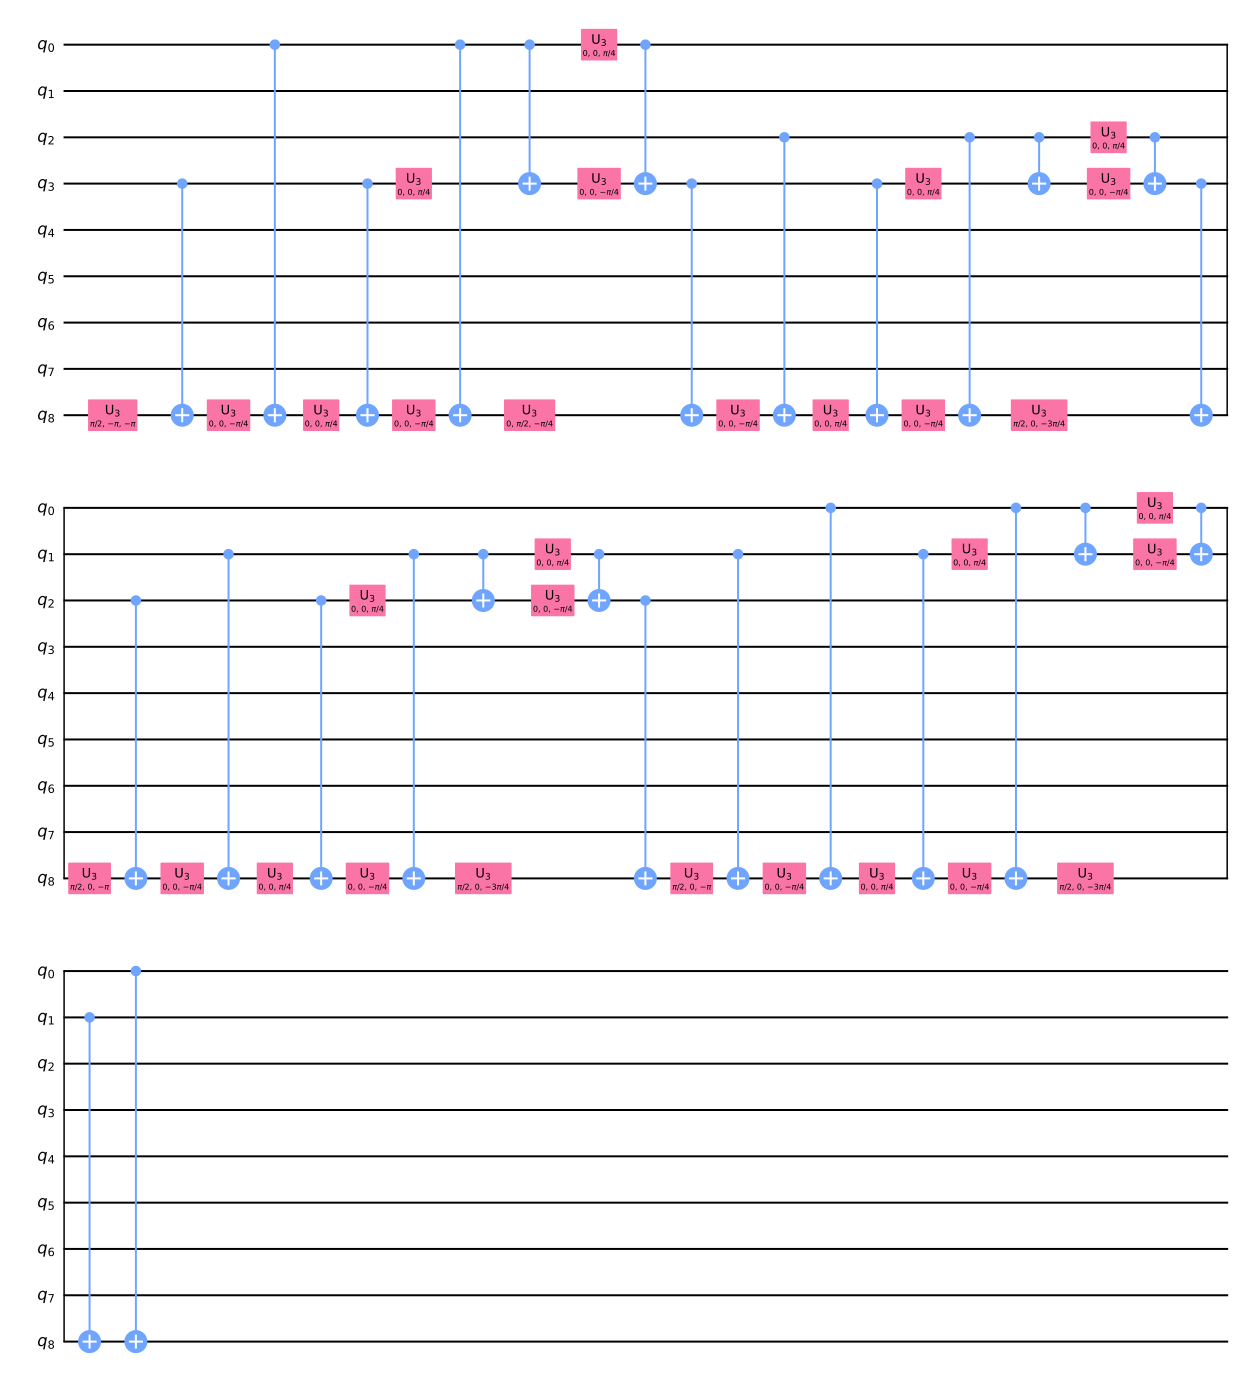

In [4]:
from qiskit import transpile
opt_qc = transpile(qc, basis_gates=['u3', 'cx'], optimization_level=3)
opt_qc.draw(output='mpl', style='clifford')

In [5]:
from qiskit.quantum_info import Statevector
print("original circuit depth: ", qc.depth())
print("transpiled circuit depth: ", opt_qc.depth())
print("PyZX circuit depth: ", zx_qc.depth())
print(Statevector.from_instruction(qc).equiv(Statevector.from_instruction(zx_qc)))

original circuit depth:  15
transpiled circuit depth:  47
PyZX circuit depth:  36
True


As can be seen, the ZX logic provides an improvement by reducing the depth of the transpiled circuit.

## Compatibility with Error Mitigation

We now verify whether we can also apply some error mitigation technique, specifically Digital Dynamic Decoupling (DDD, where sequences of gates are applied to idle windows to reduce the coupling between the qubits and the environment), alongside this ZX method. To do so, we add classical registers to be able to measure and track the evolution of the initial state. Code-wise, we use circ to define ddd rules and define an error model on all qubits with Qiskit's NoiseModel().

In [6]:
def add_measurements_to_all(circuit):
    """Adds a classical register and measures all qubits if not already present."""
    from qiskit import ClassicalRegister
    if circuit.num_clbits < circuit.num_qubits:
        creg = ClassicalRegister(circuit.num_qubits, "c")
        circuit.add_register(creg)
    for q in range(circuit.num_qubits):
        qubit = circuit.qubits[q]
        # Only add measurement if not already present for this qubit
        if not any(
            inst.operation.name == "measure" and inst.qubits[0] == qubit
            for inst in circuit.data
        ):
            circuit.measure(q, q)
    return circuit

# Apply to all relevant circuits
qc = add_measurements_to_all(qc)
opt_qc = add_measurements_to_all(opt_qc)
zx_qc = add_measurements_to_all(zx_qc)

In [7]:
import cirq

# Defining a function for the repeated ixix rule
def rep_ixix_rule(window_length: int) -> Callable[[int], QPROGRAM]:
    return ddd.rules.repeated_rule(window_length, [cirq.I, cirq.X, cirq.I, cirq.X])

# Defining a function for the repeated xx rule
def rep_xx_rule(window_length: int) -> Callable[[int], QPROGRAM]:
    return ddd.rules.repeated_rule(window_length, [cirq.X, cirq.X])

    # Defining a function for the repeated xx rule
def rep_yy_rule(window_length: int) -> Callable[[int], QPROGRAM]:
    return ddd.rules.repeated_rule(window_length, [cirq.Y, cirq.Y])

In [8]:
# coherent error
err = QuantumCircuit(1, 1)
err.rx(0.2,0)
u_err = qi.Operator(err)

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(coherent_unitary_error(u_err), ['id','y','h'])

We compare the average of noisy runs without mitigation with the ideal case (no noise) and with the noisy runs with mitigation applied.

In [9]:
num_qubits = 9  # Number of qubits in the circuit

# Define other parameters
reps = 100000
#noise = get_combined_noise(error_meas, error_phase_amplitude_damping)
ddd_flag = True
shots = 10000
ddd_sequence = rep_yy_rule  # Use appropriate DDD sequence from mitiq

circuit = qc

# Apply DDD (if required) and run the circuit
counts = apply_ddd_and_run(
    circuit,
    noise=noise_model,
    reps=reps,
    ddd=False,
    ddd_rule=ddd_sequence,
    output=True,
    simulated_hardware=False
)

#print(counts)

total = sum(counts.values())
probabilities = {k: v / total for k, v in counts.items()}
print(probabilities)


counts_ideal = apply_ddd_and_run(
    circuit,
    noise=None,
    reps=reps,
    ddd=ddd_flag,
    ddd_rule=ddd_sequence,
    output=True,
    simulated_hardware=False
)

# Apply the mitigator (if required) to the results
total = sum(counts_ideal.values())
probabilities_ideal = {k: v / total for k, v in counts_ideal.items()}
print(probabilities_ideal)


counts_mitigated = apply_ddd_and_run(
    circuit,
    noise=noise_model,
    reps=reps,
    ddd=ddd_flag,
    ddd_rule=ddd_sequence,
    output=True,
    simulated_hardware=False
)

total = sum(counts_mitigated.values())
probabilities_mitigated = {k: v / total for k, v in counts_mitigated.items()}
print(probabilities_mitigated)


Running the circuit ... for 100000 repetitions 

{'100000000': 0.91352, '000000000': 0.08648}
Original circuit
                                                                           »
q_0: ───────────────────────■────────────────────────────────────────────■─»
                            │                                            │ »
q_1: ───────────────────────┼───────────────────────■────────────────────■─»
                            │                       │                ┌─┐ │ »
q_2: ───────────────────────┼──■────────────────────■────────■───────┤M├─┼─»
                            │  │                ┌─┐ │        │       └╥┘ │ »
q_3: ───────────────────────■──■────────■───────┤M├─┼────────┼────────╫──┼─»
          ┌─┐               │  │        │       └╥┘ │        │        ║  │ »
q_4: ─────┤M├───────────────┼──┼────────┼────────╫──┼────────┼────────╫──┼─»
          └╥┘┌─┐            │  │        │        ║  │        │        ║  │ »
q_5: ──────╫─┤M├────────────┼──┼────────┼─

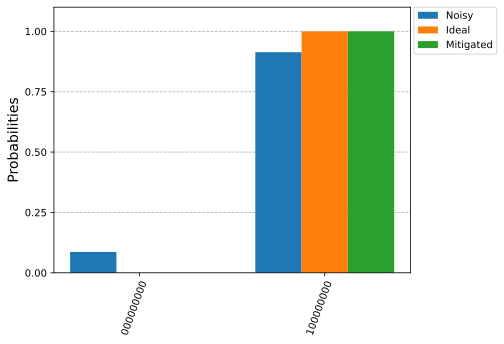

{'100000000': 0.942}


In [10]:
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

labels = ['Noisy', 'Ideal', 'Mitigated']
threshold = 0.01

def filter_probs(probs, threshold):
    return {k: v for k, v in probs.items() if v >= threshold}

filtered_data = [
    filter_probs(probabilities, threshold),
    filter_probs(probabilities_ideal, threshold),
    filter_probs(probabilities_mitigated, threshold)
]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Now, use the ax parameter to specify where to plot the histogram
plot_histogram(filtered_data, legend=labels, bar_labels=False, ax=ax)
ax.set_ylabel('Probabilities')
plt.show()


print(filter_probs(probabilities_mitigated, threshold))

We notice an improvement from the mitigation, as expected, showing the compatibility of the ZX logic and this basic mitigation technique.